In [1]:
spark

In [2]:
from collections import namedtuple
import datetime
import json
from typing import Dict

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import average_precision_score

from pyspark.sql import Row, Window, types
import pyspark.sql.functions as sf

%load_ext autoreload
%autoreload 2

In [3]:
import project_utils
import bks_utils
import propensity_utils
from kdevries.analysis_utils import show_sorted_frequencies as ssf

In [4]:
import sys
import bkng.data

In [5]:
bks_utils.create_h2o_context_on_bks()

Waiting for pods
Waiting for pods
Waiting for pods
Waiting for pods
Waiting for pods
Waiting for pods
Connecting to H2O server at http://bigdata-g99lee0jue:54321/gateway/eu-nl-c/g99lee0jue/h2o ... successful.


H2O_cluster_uptime:,28 secs
H2O_cluster_timezone:,+01:00
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 29 days
H2O_cluster_name:,user33922
H2O_cluster_total_nodes:,2
H2O_cluster_free_memory:,30 Gb
H2O_cluster_total_cores:,112
H2O_cluster_allowed_cores:,112
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.32.0.2-1-3.0
 * H2O name: spark
 * cluster size: 2
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,10.239.196.19,54321)
  (1,10.239.193.237,54321)
  ------------------------

  Open H2O Flow in browser: http://bigdata-g99lee0jue:54321/gateway/eu-nl-c/g99lee0jue/h2o (CMD + click in Mac OSX)

    


# Get data

In [8]:
from project_utils import DATA_START_DATE, DATA_END_DATE, ANALYSIS_START_DATE
data_df = (
    project_utils
    .get_data_df(DATA_START_DATE, DATA_END_DATE)
    .repartition(20)
    .cache()
)
data_df = project_utils.add_week_start_date_column(data_df, time_col="timestamp")

Info: Forcing materialisation by calculating distinct count: 1696926
Info: Verifying the number of original rows is preserved


# Train and test dates

In [10]:
test_week_start_dates = project_utils.get_week_start_date_range(start=ANALYSIS_START_DATE, end=DATA_END_DATE)

# Prepare H2O Frame

In [11]:
metadata = json.load(open("incremental_learning_boreas_config.json"))
metadata = project_utils.set_default_model_params(metadata)
metadata = project_utils.move_categorical_features_to_numerical(metadata)
metadata["dates"] = None 

In [12]:
import propensity_utils

In [13]:
data_df = propensity_utils.add_label_and_selector_cols(data_df, test_week_start_dates)
data_h2o_df = project_utils.spark_to_h2o_frame(data_df, metadata)
data_h2o_df = propensity_utils.cast_label_and_selector_cols_as_factor(data_h2o_df, test_week_start_dates)

# Train models

In [14]:
from h2o.estimators import H2ORandomForestEstimator 

In [20]:
models = {"fraud": {}, "non-fraud": {}}
features = metadata["numerical_features"] + metadata["categorical_features"]

for test_week_start_date in test_week_start_dates:
    print(f"Test week start date: {test_week_start_date}")
    target = propensity_utils.get_week_train_test_col_name(test_week_start_date)
    train_h2o_df = propensity_utils.get_train_h2o_df(data_h2o_df, test_week_start_date)
    print("   Train/test classifier for Fraud")
    model = H2ORandomForestEstimator(nfolds=5, max_depth=5, ntrees=50)
    model.train(x=features, y=target, training_frame=train_h2o_df[train_h2o_df["binary_label"]=="1"])
    models["fraud"][test_week_start_date] = model    
    print("   Train/test classifier for Non-Fraud")
    model = H2ORandomForestEstimator(nfolds=5, max_depth=5, ntrees=50)
    model.train(x=features, y=target, training_frame=train_h2o_df[train_h2o_df["binary_label"]=="0"])
    models["non-fraud"][test_week_start_date] = model

Test week start date: 2019-12-02
   Train/test classifier for Fraud


Dropping bad and constant columns: [email_address_hash_distinct_count_detected_country_1dly_30d2h_2h]


drf Model Build progress: |███████████████████████████████████████████████| 100%
   Train/test classifier for Non-Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
Test week start date: 2019-12-09
   Train/test classifier for Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
   Train/test classifier for Non-Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
Test week start date: 2019-12-16
   Train/test classifier for Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
   Train/test classifier for Non-Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
Test week start date: 2019-12-23
   Train/test classifier for Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
   Train/test classifier for Non-Fraud
drf Model Build progress: |██████████████████████████████████████████████

drf Model Build progress: |███████████████████████████████████████████████| 100%
Test week start date: 2020-07-06
   Train/test classifier for Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
   Train/test classifier for Non-Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
Test week start date: 2020-07-13
   Train/test classifier for Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
   Train/test classifier for Non-Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
Test week start date: 2020-07-20
   Train/test classifier for Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
   Train/test classifier for Non-Fraud
drf Model Build progress: |███████████████████████████████████████████████| 100%
Test week start date: 2020-07-27
   Train/test classifier for Fraud
drf Model Build progress: |█████████████████

# Plots

In [22]:
def get_importance_sorted_features(models: Dict[datetime.date, H2ORandomForestEstimator]):
    FeatureImportanceRow = namedtuple("FeatureImportanceRow", "test_week_start_date feature_name feature_importance")
    all_feature_importances = pd.DataFrame(
        FeatureImportanceRow(test_week_start_date, feature_name, feature_importance)
        for test_week_start_date, model in models.items()
        for feature_name, _, _, feature_importance in model.varimp()
    )    
    return (
        all_feature_importances
        .groupby("feature_name")
        .mean()
        .sort_values("feature_importance", ascending=False)
        .index
        .to_list()
    )

In [23]:
importance_sorted_features = {k: get_importance_sorted_features(models[k]) for k in ["fraud", "non-fraud"]}

In [24]:
def get_propensity_classifier_results(
    models: Dict[datetime.date, H2ORandomForestEstimator],
    importance_sorted_features,
    k_most_important=10    
):
    result = pd.DataFrame(
        (test_week_start_date, *get_model_results(model, importance_sorted_features, k_most_important))
        for test_week_start_date, model in models.items() 
    )
    result.columns = (
        ["test_week_start_date", "pr_auc", "roc_auc"] + 
        importance_sorted_features[:k_most_important] + 
        ["other"] + ["total", "test"]
    )
    result["test_prevalence"] = result["test"]/result["total"]
    return result
    
    
def get_model_results(
    model,
    importance_sorted_features,
    k_most_important=10    
):
    return (
        model.aucpr(),
        model.auc(), 
        *get_variable_importances_result(
            model, 
            importance_sorted_features,
            k_most_important=10
        ),
        *get_total_test_counts(model)
    )
    
def get_variable_importances_result(
    model, 
    importance_sorted_features,
    k_most_important=10
):
    variable_importances = {
        feature_name: feature_importance
        for feature_name, _, _, feature_importance in model.varimp()
    }
    highest_importances = [
        variable_importances.get(f, 0) 
        for f in importance_sorted_features[:k_most_important]
    ]
    sum_other_importances = sum(
        variable_importances.get(f, 0) 
        for f in importance_sorted_features[k_most_important:]
    )
    return highest_importances + [sum_other_importances]

def get_total_test_counts(model):
    ((tn, fp), (fn, tp)) = model.confusion_matrix().to_list()
    total = tn + fp + fn + tp
    test = tp + fp
    return total, test

In [25]:
propensity_classifier_results = {k: get_propensity_classifier_results(
    models[k], 
    importance_sorted_features[k], 
    k_most_important=10
) for k in ["fraud", "non-fraud"]}

In [29]:
importance_sorted_features["fraud"][:10]

['country_pbb_age',
 'email_address_hash_distinct_count_detected_country_1dly_30d2h_2h',
 'property_pbb_age',
 'sum_sales_hotel_cc1_4_0_wk',
 'rate_fts_hotel_cc1_4_0_wk',
 'proba_booker_cc1_given_hotel_cc1',
 'proba_language_code_given_hotel_cc1',
 'proba_issuer_cc1__language_code_given_hotel_cc1',
 'proba_hotel_cc1_given_booker_cc1',
 'proba_hotel_cc1_given_language_code']

In [30]:
importance_sorted_features["non-fraud"][:10]

['country_pbb_age',
 'log_time_since_first_ok_bkg',
 'email_address_hash_distinct_count_detected_country_1dly_30d2h_2h',
 'property_pbb_age',
 'log_time_since_second_ok_bkg',
 'proba_booker_cc1__issuer_cc1_given_hotel_cc1',
 'proba_issuer_cc1__language_code_given_hotel_cc1',
 'sum_sales_hotel_cc1_4_0_wk',
 'proba_hotel_cc1__language_code_given_issuer_cc1',
 'proba_hotel_cc1__issuer_cc1_given_booker_cc1']

In [32]:
propensity_classifier_results["fraud"].head(10)

,test_week_start_date,pr_auc,roc_auc,country_pbb_age,email_address_hash_distinct_count_detected_country_1dly_30d2h_2h,property_pbb_age,sum_sales_hotel_cc1_4_0_wk,rate_fts_hotel_cc1_4_0_wk,proba_booker_cc1_given_hotel_cc1,proba_language_code_given_hotel_cc1,proba_issuer_cc1__language_code_given_hotel_cc1,proba_hotel_cc1_given_booker_cc1,proba_hotel_cc1_given_language_code,other,total,test,test_prevalence
0,2019-12-02,0.682515,0.891354,0.519387,0.0,0.038967,0.007450,0.004720,0.015166,0.016365,0.010806,0.037450,0.004831,0.344857,4141,71,0.017146
1,2019-12-09,0.690909,0.893104,0.574559,0.0,0.026779,0.011497,0.005919,0.029649,0.023651,0.024907,0.038445,0.014841,0.249754,4415,66,0.014949
2,2019-12-16,0.729450,0.897194,0.638952,0.0,0.059786,0.010908,0.006079,0.022457,0.023392,0.013728,0.014600,0.003289,0.206811,4680,71,0.015171
3,2019-12-23,0.668949,0.901216,0.724719,0.0,0.030704,0.016745,0.006023,0.023585,0.011966,0.006235,0.008724,0.011045,0.160253,4841,84,0.017352
4,2019-12-30,0.743267,0.923125,0.508457,0.0,0.021828,0.041266,0.008510,0.062414,0.019794,0.008690,0.029500,0.010262,0.289279,4994,77,0.015419
5,2020-01-06,0.635711,0.897133,0.710228,0.0,0.026564,0.015403,0.010720,0.004299,0.008257,0.009306,0.016809,0.004356,0.194057,5193,72,0.013865
6,2020-01-13,0.658126,0.888876,0.703636,0.0,0.024882,0.007547,0.011305,0.015367,0.012764,0.019537,0.027607,0.001455,0.175900,5395,64,0.011863
7,2020-01-20,0.755717,0.894435,0.566855,0.0,0.012372,0.010799,0.020856,0.029892,0.028381,0.022082,0.008442,0.016179,0.284141,5664,88,0.015537
8,2020-01-27,0.743479,0.929149,0.605029,0.0,0.033081,0.012104,0.011634,0.012107,0.024601,0.010068,0.012933,0.019790,0.258652,5922,74,0.012496
9,2020-02-03,0.784156,0.927170,0.678597,0.0,0.032211,0.012681,0.016592,0.022483,0.027198,0.015018,0.012298,0.011574,0.171348,6022,92,0.015277


In [33]:
propensity_classifier_results["non-fraud"].head(10)

,test_week_start_date,pr_auc,roc_auc,country_pbb_age,log_time_since_first_ok_bkg,email_address_hash_distinct_count_detected_country_1dly_30d2h_2h,property_pbb_age,log_time_since_second_ok_bkg,proba_booker_cc1__issuer_cc1_given_hotel_cc1,proba_issuer_cc1__language_code_given_hotel_cc1,sum_sales_hotel_cc1_4_0_wk,proba_hotel_cc1__language_code_given_issuer_cc1,proba_hotel_cc1__issuer_cc1_given_booker_cc1,other,total,test,test_prevalence
0,2019-12-02,0.852797,0.954397,0.679674,0.122907,0.0,0.027601,0.035756,0.016828,0.013082,0.015553,0.013565,0.006066,0.068968,798376,14703,0.018416
1,2019-12-09,0.840439,0.953336,0.550022,0.121574,0.0,0.049709,0.050489,0.029484,0.024899,0.019962,0.010008,0.007414,0.136439,835856,14384,0.017209
2,2019-12-16,0.833736,0.956054,0.643591,0.135102,0.0,0.022232,0.030335,0.018309,0.017742,0.008320,0.007917,0.018093,0.098359,867767,14251,0.016423
3,2019-12-23,0.825783,0.953764,0.566661,0.187182,0.0,0.058000,0.042046,0.022170,0.016253,0.010643,0.002592,0.011262,0.083192,895523,14319,0.015990
4,2019-12-30,0.835800,0.959389,0.655426,0.091496,0.0,0.038485,0.048210,0.019493,0.021681,0.011988,0.007083,0.010308,0.095831,925282,15409,0.016653
5,2020-01-06,0.867385,0.967198,0.695596,0.093857,0.0,0.024743,0.034359,0.012918,0.008637,0.009845,0.008319,0.006461,0.105265,955536,19235,0.020130
6,2020-01-13,0.863502,0.961529,0.638561,0.096568,0.0,0.047150,0.054766,0.010244,0.022350,0.012784,0.004268,0.007537,0.105771,979302,20790,0.021229
7,2020-01-20,0.848079,0.957078,0.690805,0.083216,0.0,0.023133,0.053996,0.011478,0.010232,0.006756,0.007345,0.011283,0.101756,1001547,19083,0.019054
8,2020-01-27,0.872754,0.964792,0.623775,0.120486,0.0,0.049098,0.042287,0.014957,0.019212,0.009387,0.005476,0.010119,0.105204,1025916,19397,0.018907
9,2020-02-03,0.869544,0.965573,0.586448,0.124627,0.0,0.055219,0.046590,0.017569,0.016442,0.007851,0.012329,0.014550,0.118375,1032920,19505,0.018883


In [34]:
def propensity_plot(d_dict, y, d_key, ylim=(0, 1)):
    d = d_dict[d_key]
    date = d["test_week_start_date"]
    plt.plot(date, d[y], marker="o")
    plt.ylim(ylim)
    plt.title(f"{y!r} for train/test classifier: {d_key}")
    plt.xticks(rotation=90)
    plt.xlabel("Date Test week") 
    plt.grid()

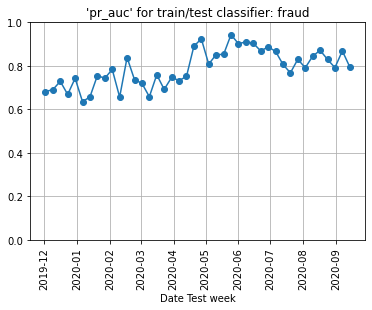

In [35]:
propensity_plot(propensity_classifier_results, "pr_auc", "fraud")

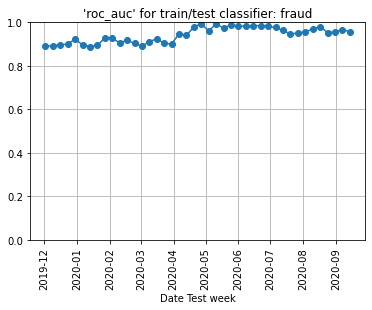

In [36]:
propensity_plot(propensity_classifier_results, "roc_auc", "fraud")

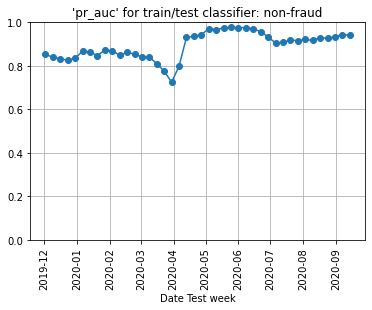

In [37]:
propensity_plot(propensity_classifier_results, "pr_auc", "non-fraud")

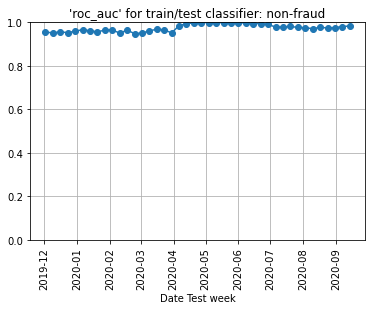

In [38]:
propensity_plot(propensity_classifier_results, "roc_auc", "non-fraud")

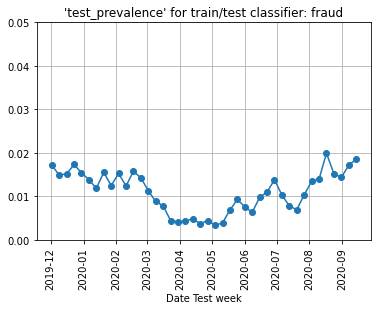

In [39]:
propensity_plot(propensity_classifier_results, "test_prevalence", "fraud", ylim=(0.0, 0.05))

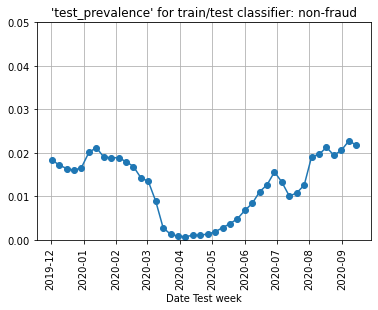

In [40]:
propensity_plot(propensity_classifier_results, "test_prevalence", "non-fraud", ylim=(0.0, 0.05))

In [41]:
propensity_classifier_results["fraud"].to_csv("propensity_classifier_results_fraud.csv")

In [42]:
propensity_classifier_results["non-fraud"].to_csv("propensity_classifier_results_non_fraud.csv")

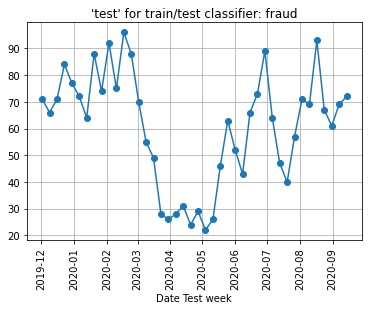

In [44]:
propensity_plot(propensity_classifier_results, "test", "fraud", ylim=None)

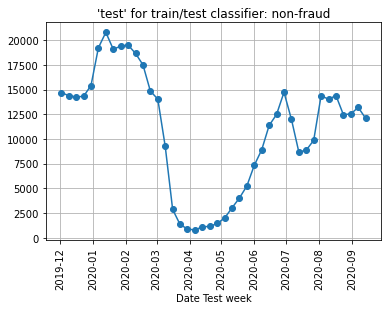

In [45]:
propensity_plot(propensity_classifier_results, "test", "non-fraud", ylim=None)

In [54]:
def plot_importances(d_dict, d_key, importance_columns):
    # data
    d = d_dict[d_key]
    date = d["test_week_start_date"]
    importances = [d[c] for c in importance_columns]

    # colors
    tab_color_suffixes = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]
    colors = [f"tab:{color_suffix}" for color_suffix in tab_color_suffixes] + ["darkblue"]

    # plot
    _, ax = plt.subplots(1)
    ax.stackplot(date, *importances, labels=importance_columns, colors=colors)
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5))
    # the rest
    plt.title(f"Feature importances for train/test classifier: {d_key}")
    plt.xticks(rotation=90)
    plt.xlabel("Date Test week") 
    plt.grid()

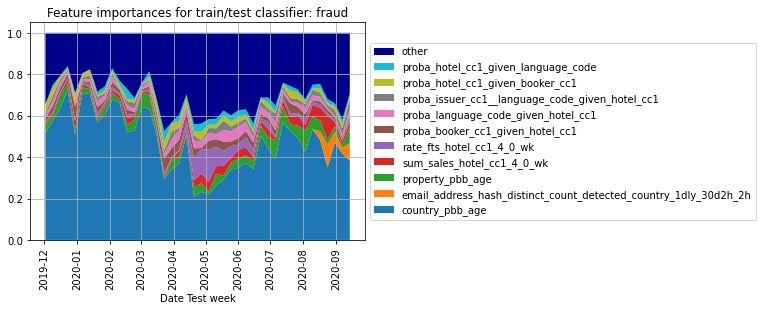

In [55]:
IMPORTANCE_START_INDEX = 3
NUM_IMPORTANCE_COLUMNS = 11
columns = propensity_classifier_results["fraud"].columns.to_list()
importance_columns = columns[IMPORTANCE_START_INDEX:IMPORTANCE_START_INDEX+NUM_IMPORTANCE_COLUMNS]

plot_importances(propensity_classifier_results, "fraud", importance_columns)

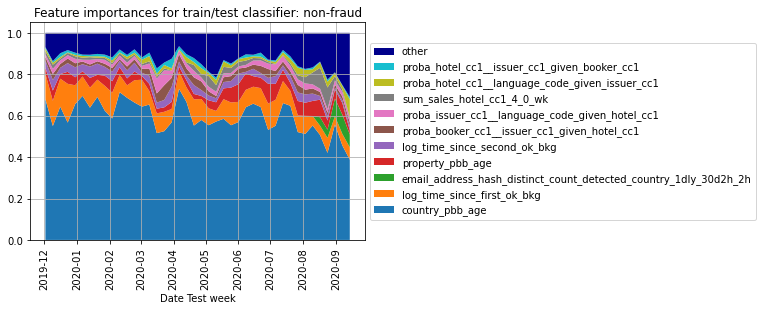

In [56]:
IMPORTANCE_START_INDEX = 3
NUM_IMPORTANCE_COLUMNS = 11
columns = propensity_classifier_results["non-fraud"].columns.to_list()
importance_columns = columns[IMPORTANCE_START_INDEX:IMPORTANCE_START_INDEX+NUM_IMPORTANCE_COLUMNS]

plot_importances(propensity_classifier_results, "non-fraud", importance_columns)